In [1]:
import numpy as np
import pylab as plt
import h5py

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')

In [3]:
f.keys()

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>

Donwsample the data for debugging purposes

In [4]:
howmany=int(1e5)

In [5]:
X=[]
for l in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']:
#for l in ['mtot', 'q','z']:
    X.append(f[l][:howmany])
X = np.array(X).T

y = np.array(f['det'][:howmany])


In [6]:
np.sum(y)/len(y)

0.14382

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10,criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

In [9]:
y_pred = clf.predict(X_test)

In [10]:
# Confusion matrix
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
C

array([[25033,   645],
       [  673,  3649]])

In [11]:
# Efficiency (i.e. number of things classified correctly)
np.sum(C.diagonal())/len(y_test)

0.9560666666666666

In [12]:
# These are the counts
tn, fp, fn, tp = C.ravel()
print(fn)

673


In [13]:
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_prob)

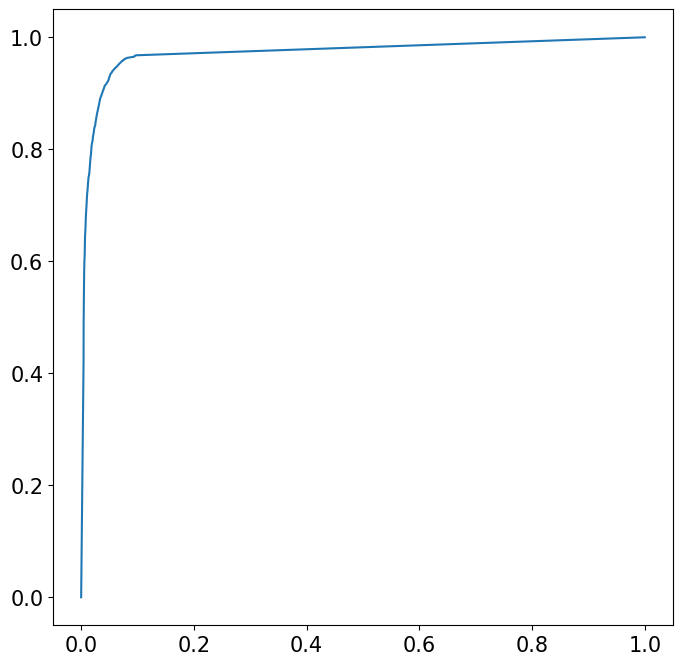

In [14]:
plt.plot(fpr, tpr)

In [15]:
completeness_test = []
contamination_test = []
completeness_train = []
contamination_train = []

md_vals = np.arange(1,20)
for md in tqdm(md_vals):
    clf = DecisionTreeClassifier(random_state=1, max_depth=md,criterion='entropy')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    C = sklearn.metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_test.append(tp/(tp+fn))
    contamination_test.append(fp/(tp+fp))

    y_pred = clf.predict(X_train)
    C = sklearn.metrics.confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = C.ravel()
    completeness_train.append(tp/(tp+fn))
    contamination_train.append(fp/(tp+fp))
    

  0%|          | 0/19 [00:00<?, ?it/s]

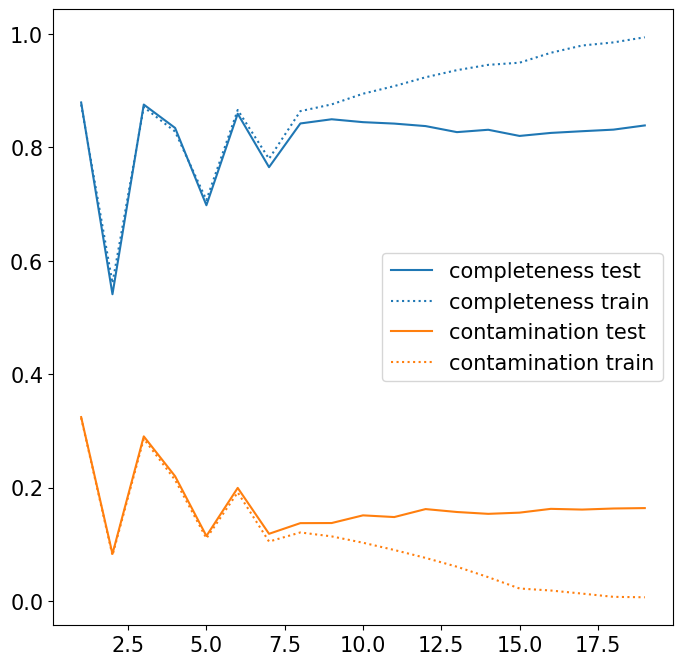

In [18]:
plt.plot(md_vals,completeness_test,label='completeness test',c='C0')
plt.plot(md_vals,completeness_train,label='completeness train',c='C0',ls='dotted')

plt.plot(md_vals,contamination_test,label='contamination test',c='C1')
plt.plot(md_vals,contamination_train,label='contamination train',c='C1',ls='dotted')
plt.legend()


From the plot above, I'm going to use max-depth=7, which is before I start overfitting.

In [19]:
print("completeness test", np.array(completeness_test)[md_vals==7])
print("contamination test", np.array(contamination_test)[md_vals==7])
print("completeness train", np.array(completeness_train)[md_vals==7])
print("contamination train", np.array(contamination_train)[md_vals==7])

completeness test [0.76515502]
contamination test [0.11883826]
completeness train [0.77992048]
contamination train [0.10515511]


Let's see if I can improve things with a random forest


In [20]:
clf = RandomForestClassifier(n_estimators=200, max_depth=7, criterion='entropy',n_jobs=-1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness test", tp/(tp+fn))
print("contamination test", fp/(tp+fp))

y_pred = clf.predict(X_train)
C = sklearn.metrics.confusion_matrix(y_train, y_pred)
tn, fp, fn, tp = C.ravel()
print("completeness train", tp/(tp+fn))
print("contamination train", fp/(tp+fp))

completeness test 0.8056455344747802
contamination test 0.0995603827256271
completeness train 0.8125248508946322
contamination train 0.08995769316410598


That's a nice improvement.

In [21]:
y_pred = clf.predict(X_test)
C = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.sum(C.diagonal())/len(y_test)

0.9591666666666666

**Some of my failed attempts and thoughts**:
- I tried boosting but didn't do much better on this problem despite the large computational cost
- Things are not as nice for other values of max-depth, not sure why.
- Looks like the "class_weight" key is important and changes the balance between completeness and contamination.
- I do not understand those oscillations between even and odd number of splitting level. They disappear when using the gini criterion instead of entropy, which I also don't understand.

(remember: these are not supposed to be "solutions"! I'm showing them just in case you need something to start from, but you should do your own exploration and do much better than I did here!)